In [1]:
from model.AutoEncoder import VQModel
import yaml
import torch
import sys
sys.path.append("/mnt/lustre/zhengjinliang/taming-transformers")
# This line of code is used to choose a model
model_name = 'vq-f4'

with open(f"/mnt/lustre/zhengjinliang/vision-language-model/ldm/configs/{model_name}/config.yaml", "r") as f:
    file = yaml.load(f.read(), Loader=yaml.FullLoader)
model_kwargs = file['model']['params']
m = VQModel(**model_kwargs)
state = torch.load(f"/mnt/lustre/zhengjinliang/vision-language-model/ldm/configs/{model_name}/model.ckpt", map_location='cpu')
state = state['state_dict']
m.load_state_dict(state)

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
loaded pretrained LPIPS loss from /mnt/lustre/zhengjinliang/.cache/torch/hub/checkpoints/vgg16-397923af.pth
VQLPIPSWithDiscriminator running with hinge loss.
suc!!!


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([5584, 2697, 4383,  ..., 2999, 6795, 3768])


2304

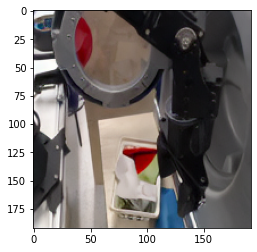

In [5]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
img = Image.open("/mnt/lustre/zhengjinliang/vision-language-model/ldm/im_0.jpg")
img = img.convert('RGB')
img = img.resize((192,192))
img = transforms.ToTensor()(img)
img = img.unsqueeze(0)
out, diff, indices = m(img, return_pred_indices=True)
plt.imshow(out.squeeze().permute(1, 2, 0).detach().numpy())
print(indices)
len(indices)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1777, 2973, 5724,  ..., 2366, 1054, 4309])


torch.Size([1024, 3])

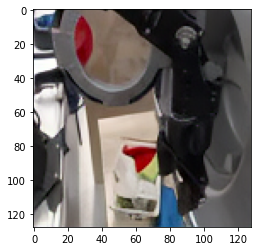

In [8]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
img = Image.open("/mnt/lustre/zhengjinliang/vision-language-model/ldm/im_0.jpg")
img = img.convert('RGB')
img = img.resize((128,128))
img = transforms.ToTensor()(img)
img = img.unsqueeze(0)
out, diff, indices = m(img, return_pred_indices=True)
plt.imshow(out.squeeze().permute(1, 2, 0).detach().numpy())
print(indices)
len(indices)
codes = m.quantize.get_codebook_entry(indices, None)
codes.shape

In [36]:
from dataset import build_imagenet_for_vqvae
from easydict import EasyDict
from PIL import Image
import matplotlib.pyplot as plt
data_args = EasyDict(
    dict(
        color_jitter = 0.4,
        input_size = 224,
        min_crop_scale = 0.08,
        train_interpolation = 'bicubic',
        root_dir_train='/mnt/lustre/share/images/train/',
        root_dir_val = '/mnt/lustre/share/images/val/',
        meta_file_train= '/mnt/lustre/share/images/meta/train.txt',
        meta_file_val= '/mnt/lustre/share/images/meta/val.txt'
    )
)
dataset = build_imagenet_for_vqvae(False, data_args)
train_dataset = build_imagenet_for_vqvae(True, data_args)


/mnt/cache/share/spring/conda_envs/miniconda3/envs/s0.3.5/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/mnt/cache/share/spring/conda_envs/miniconda3/envs/s0.3.5/lib/python3.7/site-packages/torchvision/transforms/transforms.py:891: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Test Data Aug: Compose(
    Resize(size=256, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
)
Train Data Aug: Compose(
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=None)
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


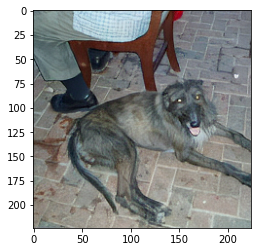

In [39]:
import random
import os
if not os.path.exists(f"output/valset_{model_name}"):
    os.mkdir(f"output/valset_{model_name}")
from torchvision.transforms import ToPILImage as unloader
length = len(dataset)
for i in random.sample(range(length), 10):
    img, label = dataset[i]
    pre_img = img.unsqueeze(0)
    # pre_img = model.pre_process(input_img)
    pre_img = pre_img.squeeze()
    pre_img = unloader()(pre_img)
    pre_img.save(f'output/valset_{model_name}/{i}_target.jpg')
    input_img = img.unsqueeze(0)
    out, diff = m(input_img)
    plt.imshow(out.squeeze().permute(1, 2, 0).detach().numpy())
    out = torch.clamp(out, 0, 1)
    plt.imsave(f'output/valset_{model_name}/{i}_generate.jpg', out.squeeze().permute(1, 2, 0).detach().numpy())
    # out_img = out.squeeze().detach()
    # out_img = unloader()(out_img)
    # out_img.save(f'output/valset/{i}_generate.jpg')